# Sentiment Analysis using the IMDb reviews dataset - RNN-based model with attention/transformers mechanisms

Ref.

Kaggle

[Sentiment Analysis of IMDB Movie Reviews - gold](https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews)

[Sentiment Analysis of IMDB Movie Reviews - cooper](https://www.kaggle.com/code/bhavikjikadara/sentiment-analysis-of-imdb-movie-reviews)

[IMDB Dataset Sentiment Analysis using RNN](https://www.kaggle.com/code/tanyildizderya/imdb-dataset-sentiment-analysis-using-rnn)

Keras

[Keras - IMDB movie review sentiment classification dataset](https://keras.io/api/datasets/imdb/)

包含 25,000 部電影評論的 IMDB 數據集，按情感（正面/負面）進行標記。評論已經過預處理，每個評論都被編碼為一個詞索引列表（整數），詞彙按照數據集中的整體頻率進行索引，所以可以快速篩選特定頻率區間的詞彙。

按照慣例，"0" 不代表特定的詞，而是用於編碼填充標記。

Benchmark

[Sentiment Analysis on IMDb](https://paperswithcode.com/sota/sentiment-analysis-on-imdb)

In [72]:
# Python version: 3.10.6


import os

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn import metrics
import numpy as np
import pandas as pd

import keras
from keras import layers, losses, optimizers
from keras.utils import pad_sequences, plot_model
from keras.datasets import imdb
from keras import backend as K
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

import nltk
from nltk.corpus import stopwords

os.environ["KERAS_BACKEND"] = "tensorflow"

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [73]:
version = "final"

# sequence preprocessing parameters
start_char = 1
oov_char = 2
index_from = 3
max_num_words = 5001
max_sequence_length = 240

# training parameters
training = False
use_cuDNN = True
embedding_output_dim = 64
num_epochs = 5
batch_size = 64
validation_split = 0.1 if training else 0.0
learning_rate = 1e-4

## Load dataset

In [74]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_num_words,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=start_char,
    oov_char=oov_char,
    index_from=index_from,
)

## EDA

In [75]:
print("Training data shape:", x_train.shape)
print("Training label shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test label shape:", y_test)

Training data shape: (25000,)
Training label shape: (25000,)
Test data shape: (25000,)
Test label shape: [0 1 1 ... 0 0 0]


In [76]:
unique, counts = np.unique(y_train, return_counts=True)
print("y train distribution: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("y test distribution: ", dict(zip(unique, counts)))

y train distribution:  {0: 12500, 1: 12500}
y test distribution:  {0: 12500, 1: 12500}


In [77]:
# 取得字典 mapping => { word: index ...}
word_index = imdb.get_word_index()

# key, value => word, index
inverted_word_index = dict((index + index_from, word) for (word, index) in word_index.items())

# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[0] = "[MASK]"
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"


def print_decoded_sequence(data, index=0):

    # X data (word sequence)

    print(np.array(data[index]))
    decoded_sequence = " ".join(inverted_word_index[i] for i in data[index])
    print(decoded_sequence)
    print(np.array(decoded_sequence.split(" ")))

    # y data (labels: positive or negative)

    print(y_train[index])

In [78]:
if max_num_words is None:
    max_num_words = len(imdb.get_word_index().items())

print(max_num_words)

print_decoded_sequence(x_train)

5001
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
    2   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117    2   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194    2   18    4  226   22   21  134  476
   26  480    5  144   30    2   18   51   36   28  224   92   25  104
 

Text(0.5, 1.0, 'y train')

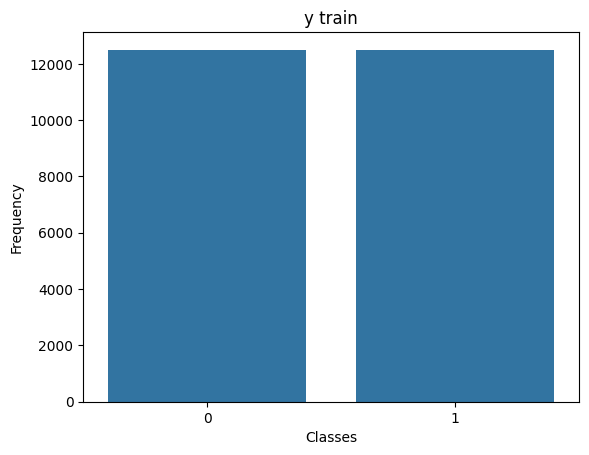

In [79]:
# training label distribution

plt.figure()
sns.countplot(pd.DataFrame(y_train, columns=["class"]), x="class")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("y train")

Text(0.5, 1.0, 'y test')

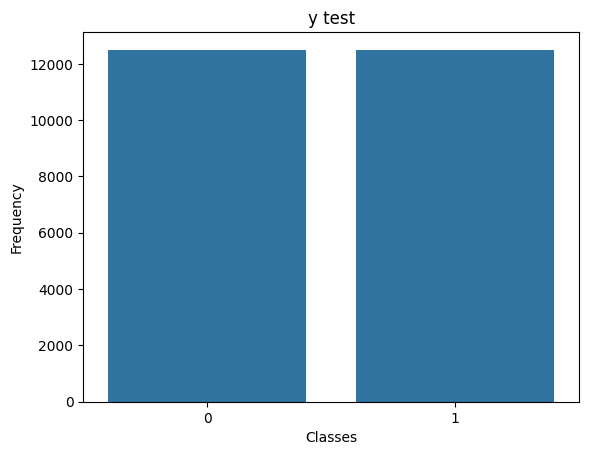

In [80]:
# test label distribution

plt.figure()
sns.countplot(pd.DataFrame(y_test, columns=["class"]), x="class")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("y test")

In [81]:
# words distribution


def visualize_sequence_distribution(x_train, x_test):
    review_len_train = []
    review_len_test = []
    for i, j in zip(x_train, x_test):
        review_len_train.append(len(i))
        review_len_test.append(len(j))

    print("min:", min(review_len_train), "max:", max(review_len_train))
    print("min:", min(review_len_test), "max:", max(review_len_test))

    sns.displot(review_len_train, rug_kws={"alpha": 0.3})
    plt.xlabel("review length")
    plt.title("review train")
    sns.displot(review_len_test, rug_kws={"alpha": 0.3})
    plt.xlabel("review length")
    plt.title("review test")

min: 11 max: 2494
min: 7 max: 2315


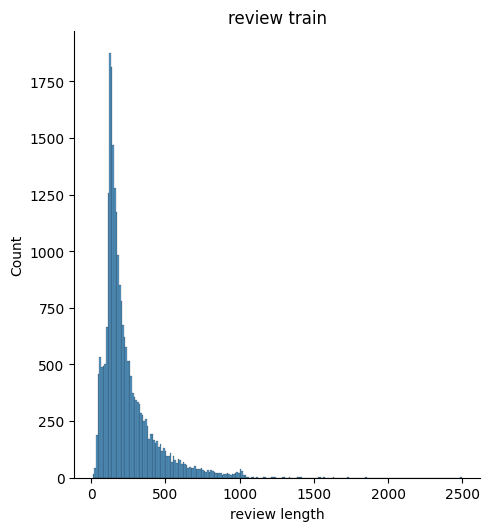

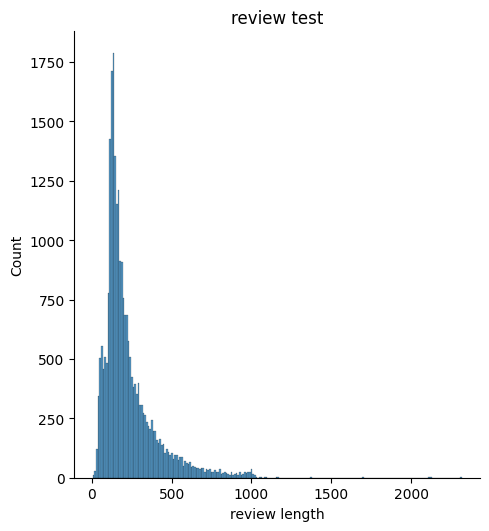

In [82]:
visualize_sequence_distribution(x_train, x_test)

In [83]:
mean_sequence_len = np.mean([len(seq) for seq in x_train])
mean_sequence_len

238.71364

## Data preprocessing

Keras's IMDB

X data : 資料已經預處理過，包括
* removing html strips
* removing special characters
* segmentation
* encoding

y data : 代表正向 (positive) 或負向 (negative) 的評論

In [84]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stop_words.add("[START]")
stop_words.add("[OOV]")


def remove_stop_words(sequences):
    filterd_sequences = []

    for sequence in sequences:
        filterd_sequences.append(
            [word_index for word_index in sequence if inverted_word_index[word_index] not in stop_words],
        )

    return filterd_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
# remove stop words
x_train = remove_stop_words(x_train.tolist())
x_test = remove_stop_words(x_test.tolist())

# 使每個 sequence 有相同的長度

x_train = pad_sequences(x_train, maxlen=max_sequence_length, padding="pre")
x_test = pad_sequences(x_test, maxlen=max_sequence_length, padding="pre")

In [86]:
print("Training data shape:", x_train.shape)
print("Training label shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test label shape:", y_test.shape)

Training data shape: (25000, 240)
Training label shape: (25000,)
Test data shape: (25000, 240)
Test label shape: (25000,)


min: 240 max: 240
min: 240 max: 240


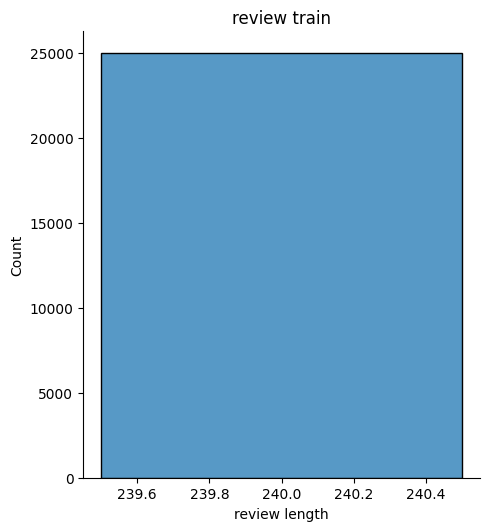

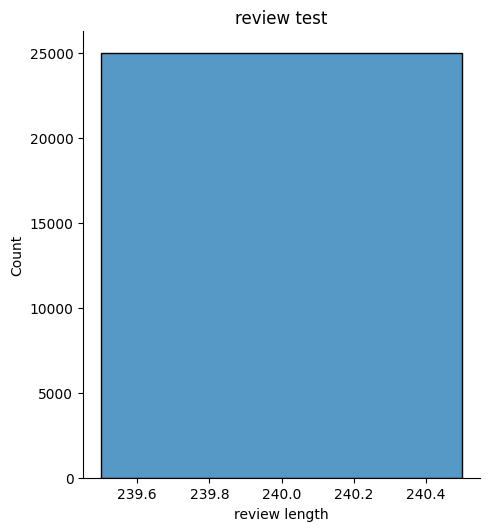

In [87]:
visualize_sequence_distribution(x_train, x_test)

In [89]:
print_decoded_sequence(x_train)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    1   22  530  973 1622 1385   65  458 4468   66
 3941  173  256  100  838  670    2  480  284  167    2  336  385 4536
 1111  447  192  147 2025   22 1920 4613  469   22   87  530   76 1247
   22  515  626    2   62  386  316  106 2223    2  480   66 3785  130
  619 

## RNN mechanism

Ref.

[一文搞懂RNN（循环神经网络）基础篇](https://zhuanlan.zhihu.com/p/30844905)

![rnn](./images/rnn.png)

S<sub>t</sub> 代表神經元在 t 時刻上，同時接收
* 輸入 X 與其輸入權重 U
* 前一次 S 在 t-1 時刻的 S<sub>t-1</sub> 與其 W (S<sub>t-1</sub> --> S<sub>t</sub> 的權重)

展開

![rnn-expand](./images/rnn-expand.png)

## Attention mechanism

Ref.

[完全解析RNN, Seq2Seq, Attention注意力机制](https://zhuanlan.zhihu.com/p/51383402)

[A simple overview of RNN, LSTM and Attention Mechanism](https://medium.com/swlh/a-simple-overview-of-rnn-lstm-and-attention-mechanism-9e844763d07b)

[注意力機制 (Attention Mechanism) 的理解與實作](https://www.kaggle.com/code/lianghsunhuang/attention-mechanism)

Attention 的架構

![attention-mechanism](./images/attention-mechanism.png)

## Build model

Ref.

[Keras 中的循环神经网络 (RNN)](https://tensorflow.google.cn/guide/keras/rnn?hl=zh-cn)

[Keras实现CNN、RNN（基于attention 的双向RNN）及两者的融合](https://blog.csdn.net/xwd18280820053/article/details/80060544)

[Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

[How to add attention layer to a Bi-LSTM](https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137)

In [ ]:
class Attention(layers.Layer):

    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):

        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):

        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

In [ ]:
rnn_activation = "selu" if not use_cuDNN else "tanh"
input_shape = max_sequence_length

input = layers.Input(shape=input_shape)

x = layers.Embedding(max_num_words, embedding_output_dim, input_length=max_sequence_length, mask_zero=True)(input)

x = layers.Bidirectional(layers.LSTM(64, activation=rnn_activation, return_sequences=True, dropout=0.5))(x)

a = Attention(return_sequences=True)(x)

p1 = layers.GlobalAveragePooling1D()(x)
p2 = layers.GlobalAveragePooling1D()(a)

merge = layers.Concatenate()([p1, p2])

merge = layers.Dropout(0.5)(merge)

x = layers.Dense(64, activation="relu")(merge)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation="softmax")(x)

model = keras.Model(input, x)

## Preview model

In [ ]:
model.build((None, max_sequence_length))
model.summary()

In [ ]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

## Train model

In [ ]:
train_history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    # verbose=0,
    batch_size=batch_size,
    validation_split=validation_split,
    # callbacks=[TqdmCallback(verbose=0)],
)

## Evaluation

In [ ]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["loss"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_loss"], "green", linewidth=2.0)
    plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title("Loss Curves", fontsize=12)

In [ ]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["accuracy"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_accuracy"], "blue", linewidth=2.0)
    plt.legend(["Training Accuracy", "Validation Accuracy"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Curves", fontsize=12)

In [ ]:
if not training:
    test_result = model.evaluate(x_test, y_test, batch_size=batch_size)

## Save result

In [ ]:
# keras.models.save_model(model, "./models/imdb-rnn-{0}".format(version), save_format="tf")

# with open("./models/imdb-rnn-{0}-history".format(version), "wb") as f:
#     pickle.dump(train_history.history, f)

## Final prediction

In [ ]:
assert not training, "Training mode can't do final prediction"

# model = keras.models.load_model("./models/imdb-rnn-{0}".format(version))

pred = model.predict(x_test)

## Test result insights

In [ ]:
confusion_metrics = metrics.confusion_matrix(y_test, np.argmax(pred, axis=1))
display = metrics.ConfusionMatrixDisplay(confusion_metrics)
fig, axes = plt.subplots(figsize=(20, 10))
display.plot(ax=axes)
plt.show()

In [ ]:
print(metrics.classification_report(y_test, np.argmax(pred, axis=1)))